# Example Notebook: Atom Mappings
In this example we want to showcase how to generate the Kartograf mappings on 
the RHFE Data set, which was used for our publication.

## Get Data:
In this cell we will load the molecules as components from openfe-benchmarks. 
Note, that openfe-benchmarks contains aligned molecules with 3D coordinates. 
It is a general assumption for Kartografs atom mapper to get input molecules 
with well aligned conformations.

/home/mmh/micromamba/envs/karto-dev-py312/lib/python3.13/site-packages/mdtraj/core/selection.py:47: DeprecationWarning: 'enablePackrat' deprecated - use 'enable_packrat'
  ParserElement.enablePackrat(cache_size_limit=304)


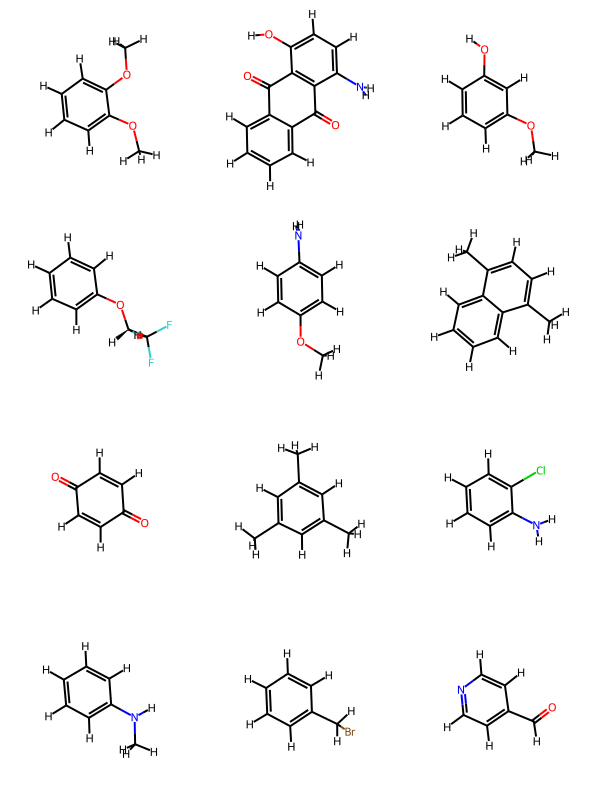

In [1]:
from rdkit import Chem

try:
    from openfe_benchmarks import benzenes
except (ModuleNotFoundError, ImportError):
    import sys  # noqa: F401

    !{sys.executable} -m pip install --no-deps git+https://github.com/OpenFreeEnergy/openfe-benchmarks.git@d5a027e4e3cb53e47d4b230e8ddffda274b70aff
    from openfe_benchmarks import benzenes


components = benzenes.get_system().ligand_components

# Exclude cycle breakers! as not feasible for Hybrid topology approaches.
not_lig = ["lig_4", "lig_7", "lig_2", "lig_3"]
components = [c for c in components if (c.name not in not_lig)]

Chem.Draw.MolsToGridImage([c.to_rdkit() for c in components])

## Generate Atom Mappings with Kartograf:
Next we will generate all possible atom mappings, for the given Ligand cA. 
These mappings will be visualized in 3D in the latter cell.

In [ ]:
from kartograf import KartografAtomMapper

atomMapper = KartografAtomMapper()

# Generate Mappings
mappings = []
cA = components[-5]  # central ligand from Ries et al. 2022
for cB in components:
    if cA != cB:
        mapping = next(atomMapper.suggest_mappings(cA, cB))
        mappings.append(mapping)

In [3]:
from kartograf.utils.mapping_visualization_widget import display_mappings_3d

display_mappings_3d(mappings)

## Scoring Metrics for Atom mappings:
Finally we want to compare the different mappings with rule-based scoring 
metrics. This way for example we can try to estimate the complexity of the 
transformation from cA to cB.

In [4]:
from kartograf.mapping_metrics import (
    MappingRMSDScorer,
    MappingShapeMismatchScorer,
    MappingShapeOverlapScorer,
    MappingVolumeRatioScorer,
)

scorer_dict = {
    "volume_score": MappingVolumeRatioScorer(),
    "rmsd_score": MappingRMSDScorer(),
    "overlap_score": MappingShapeOverlapScorer(),
    "mismatch_score": MappingShapeMismatchScorer(),
}


def apply_scorers(mapping) -> None:
    for score_name, scorer in scorer_dict.items():
        setattr(mapping, score_name, scorer(mapping))


# score mappings:
for mapping in mappings:
    apply_scorers(mapping)

([<matplotlib.axis.XTick at 0x7452c53c2ba0>,
 [Text(1, 0, 'mismatch_score'),
  Text(2, 0, 'overlap_score'),
  Text(3, 0, 'rmsd_score'),
  Text(4, 0, 'volume_score')])

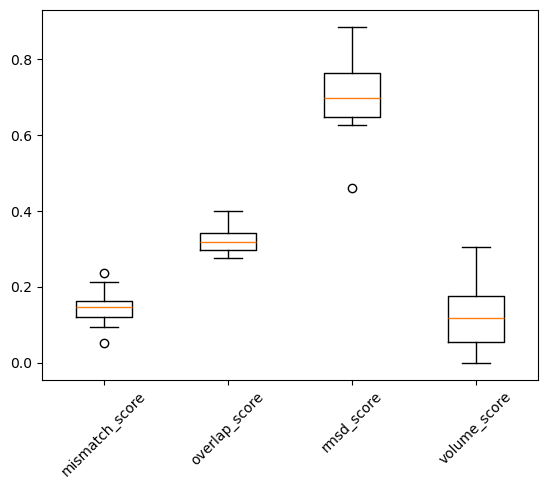

In [5]:
from matplotlib import pyplot as plt

score_names = sorted(scorer_dict)
plt.boxplot([[getattr(m, score_name) for m in mappings] for score_name in score_names])
plt.xticks(range(1, len(score_names) + 1), score_names, rotation=45)

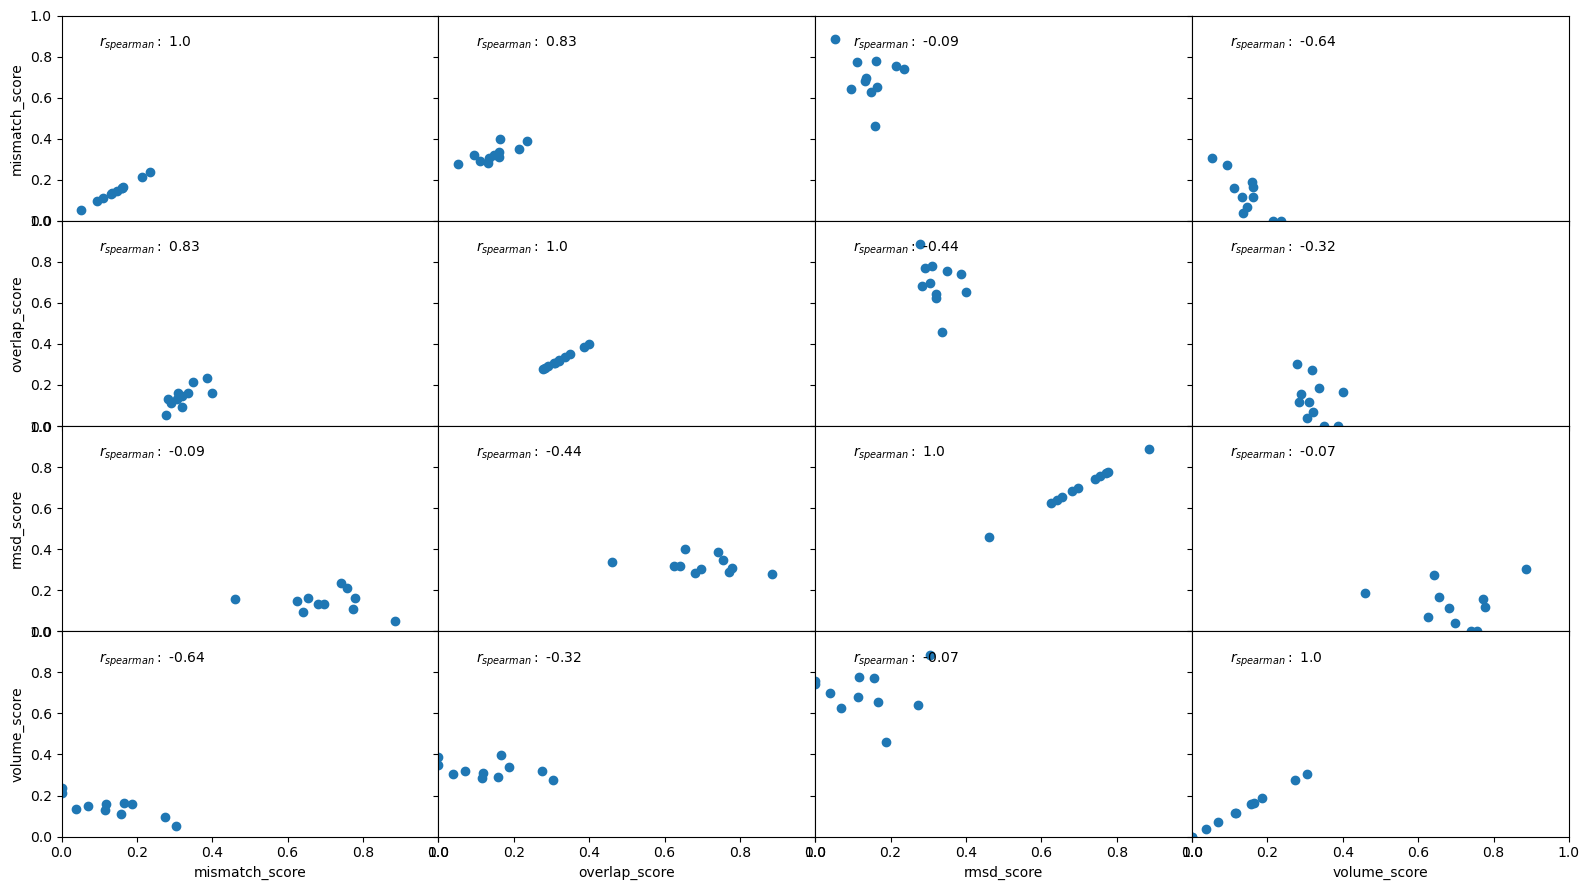

In [6]:
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

score_names = sorted(scorer_dict)
fig, axes = plt.subplots(nrows=len(score_names), ncols=len(score_names), figsize=[16, 9])

i = 0
for score_nameA in score_names:
    j = 0
    axes[i, j].set_ylabel(score_nameA)

    for score_nameB in score_names:
        ax = axes[i, j]
        if i == len(score_names) - 1:
            ax.set_xlabel(score_nameB)
        else:
            ax.set_xticklabels([])
        if j > 0:
            ax.set_yticklabels([])

        x = [getattr(m, score_nameA) for m in mappings]
        y = [getattr(m, score_nameB) for m in mappings]
        r, _ = spearmanr(x, y)
        ax.scatter(x, y)
        ax.text(0.1, 0.85, "$r_{spearman}:~$" + str(round(r, 2)))
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])

        j += 1
    i += 1
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)